##Setup and imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/benjaminrike1/social_score_csr_reports.git

Cloning into 'social_score_csr_reports'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 86 (delta 9), reused 40 (delta 9), pack-reused 46
Unpacking objects: 100% (86/86), done.
Checking out files: 100% (51/51), done.


In [3]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

     |████████████████████████████████| 4.9 MB 9.8 MB/s 
     |████████████████████████████████| 462 kB 37.4 MB/s 


In [4]:
pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 1.8 MB 5.8 MB/s 
     |████████████████████████████████| 352 kB 25.4 MB/s 
     |████████████████████████████████| 1.1 MB 53.7 MB/s 
     |████████████████████████████████| 90 kB 7.6 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 99 kB 7.4 MB/s 
     |████████████████████████████████| 237 kB 47.2 MB/s 
     |████████████████████████████████| 1.2 MB 36.8 MB/s 
     |████████████████████████████████| 47.8 MB 67 kB/s 
     |████████████████████████████████| 596 kB 46.7 MB/s 


In [5]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data

In [19]:
data_path = 'social_score_csr_reports/'

In [65]:
training = pd.read_csv(data_path+'training.csv', names=['criteria', 'label'], index_col=False)
training.head(5)

,criteria,label
0,Focus group on strengthening social,1
1,Employees contribute to ESG,1
2,All employees are provided insurance,1
3,allow employees to take leave,1
4,Occupational health system,1


In [66]:
print('Number of positive labels (training): %d'%(training[training.label==1]['label'].count()))
print('Number of neutral labels (training): %d'%(training[training.label==0]['label'].count()))
print('Number of negative labels (training): %d'%(training[training.label==-1]['label'].count()))

Number of positive labels (training): 384
Number of neutral labels (training): 47
Number of negative labels (training): 132


In [67]:
# to ensure correct values in sparse softmax
training['label'] = training['label'].apply(lambda x: 2 if x==-1 else x)

In [23]:
validation = pd.read_csv(data_path+'validation.csv', names=['criteria', 'label'], index_col=False)
validation.head(5)

,criteria,label
0,The turnover ratio has increased,-1
1,We provide free health care to all our full ti...,1
2,All employees have the right to parental leave...,1
3,We report health and safety in a standardized ...,1
4,Risk assesment is an important are of focus fo...,1


In [24]:
print('Number of positive labels (validation): %d'%(validation[validation.label==1]['label'].count()))
print('Number of neutral labels (validation): %d'%(validation[validation.label==0]['label'].count()))
print('Number of negative labels (validation): %d'%(validation[validation.label==-1]['label'].count()))

Number of positive labels (valication): 64
Number of neutral labels (valication): 17
Number of negative labels (valication): 27


In [68]:
# to ensure correct values in sparse softmax
validation['label'] = validation['label'].apply(lambda x: 2 if x==-1 else x)

In [69]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

train_feat = training['criteria']
tf.convert_to_tensor(train_feat)
train_label = training['label']
tf.convert_to_tensor(train_label)

val_feat = validation['criteria']
tf.convert_to_tensor(val_feat)
val_label = validation['label']
tf.convert_to_tensor(val_label)

train_data = (tf.data.Dataset.from_tensor_slices((train_feat, train_label))
                             .batch(batch_size=batch_size))
val_data = (tf.data.Dataset.from_tensor_slices((val_feat, val_label))
                            .batch(batch_size=batch_size))

train_ds = train_data.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = val_data.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = test_ds


## Add random neutral sentences

##Generate data augmentations

## Model

In [70]:
preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/2"

preprocessor = hub.KerasLayer(
    preprocess_path)
encoder = hub.KerasLayer(
    encoder_path,
    trainable=True)

In [71]:
def social_classifier():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocesser = hub.KerasLayer(preprocess_path, name='preprocessing')
  encoder_inputs = preprocesser(text_input)
  encoder = hub.KerasLayer(encoder_path, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(3, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

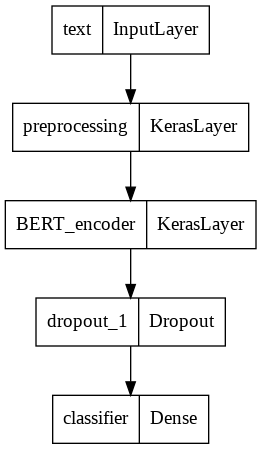

In [72]:
classifier_model = social_classifier()
tf.keras.utils.plot_model(classifier_model)


## Training

In [74]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(name='acc')

In [75]:
#using same optimzer and lr schedule as original BERT
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [76]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [77]:
print(f'Training model with Bert')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with Bert
Epoch 1/5
18/18 [==============================] - 125s 6s/step - loss: 1.1227 - acc: 0.5293 - val_loss: 0.9682 - val_acc: 0.5926
Epoch 2/5
18/18 [==============================] - 99s 6s/step - loss: 0.8209 - acc: 0.6803 - val_loss: 0.8775 - val_acc: 0.5926
Epoch 3/5
18/18 [==============================] - 106s 6s/step - loss: 0.7632 - acc: 0.6892 - val_loss: 0.8274 - val_acc: 0.6296
Epoch 4/5
18/18 [==============================] - 99s 6s/step - loss: 0.7219 - acc: 0.7034 - val_loss: 0.8126 - val_acc: 0.6481
Epoch 5/5
18/18 [==============================] - 93s 5s/step - loss: 0.7040 - acc: 0.6998 - val_loss: 0.8018 - val_acc: 0.6481


In [78]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

4/4 [==============================] - 5s 1s/step - loss: 0.8018 - acc: 0.6481
Loss: 0.8017894625663757
Accuracy: 0.6481481194496155


## Plotting accuracy over time

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


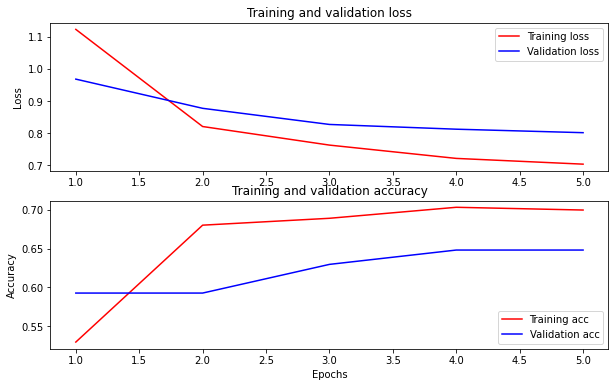

In [84]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

##Saving model

In [85]:
model_path = 'social_score_csr_reports/models/model'

classifier_model.save(model_path, include_optimizer=False)

##Loading model

In [86]:
reloaded_model = tf.saved_model.load(model_path)


In [90]:
def print_my_examples(inputs, results):
  print("Scores is on the format: neutral, positive, negative")
  result_for_printing = \
    [f'input: {inputs[i]:<30} : \nscores: {results[i]}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    #Facebook example
    'In 2020, we continued to provide a framework of policies, standards, and implementation expectations to guide our supplier business relationships',
    'In 2020, we conducted risk assessments to help us identify and prioritize the most critical issue areas and suppliers. ',
    #Cola examples
    'We invest in charitable and community causes in all of our markets and our people regularly take part in volunteering activities to support social initiatives in our communities.',
    'As signatories of the Valuable 500 pledge, we are committed to putting disability on the business leadership agenda',
    #Fake examples
    'Our diversity was reduced this year',
    'Football is a sport',
    #Cola examples
    'In 2020, 35.6% of leadership positions were held by women, up from 35.5% in 2019. ',
    'Zero fatalities occurred during the year'
]

reloaded_results = tf.nn.softmax(reloaded_model(tf.constant(examples)))

print('Results from the model:')
print_my_examples(examples, reloaded_results)

Results from the model:
Scores is on the format: neutral, positive, negative
input: In 2020, we continued to provide a framework of policies, standards, and implementation expectations to guide our supplier business relationships : 
scores: [0.09062777 0.7698006  0.13957173]
input: In 2020, we conducted risk assessments to help us identify and prioritize the most critical issue areas and suppliers.  : 
scores: [0.09333372 0.7312666  0.17539963]
input: We invest in charitable and community causes in all of our markets and our people regularly take part in volunteering activities to support social initiatives in our communities. : 
scores: [0.06588159 0.8229718  0.11114655]
input: As signatories of the Valuable 500 pledge, we are committed to putting disability on the business leadership agenda : 
scores: [0.10861464 0.63509244 0.25629297]
input: Our diversity was reduced this year : 
scores: [0.03579698 0.55751705 0.40668595]
input: Football is a sport            : 
scores: [0.08992761 